### QED-C Application-Oriented Benchmarks - Analyze Observable Methods

The notebook implements a procedure for analyzing different methods for computing observables.
Given a specific problem size (number of qubits), a Hamiltonian, an aboservable method (group_method), and a given total shot count, generate a specified number of random input states, and measure the resulting expectation value, both exactly and computed using the quantum expactation algorithm.

Results are plotted and the difference between the exact expectation value at each random input and the computed value is highlighted.

DEVNOTE: Much of the code in this notebook will be re-factored into other modules, as this work evolves.


### Program Configuration

In [ ]:
# Select the API to use and load the benchmark program
api = "qiskit"
from hamlib import hamlib_simulation_benchmark

# Select the benchmark parameters
num_qubits = min_qubits = max_qubits = 12
skip_qubits = 1
max_circuits = 1

num_shots_list = list(range(1000, 2000, 1500))
# num_shots_list = list(range(1000, 4001, 1500))

# Set number of Trotter steps K and total time t
K = 0
t = 0.001

# Number of iterations performed with random initialization
iterations = 2

use_diag_method = True
group_method = "N"

# use an ansatz to generate random states; default is to use integer initialization
use_ansatz_initial_state = True

# method to use for weighted shot distribution: max_sq, mean_sq, or max
wsd_method = "mean"

# Select the backend 
#backend_id = "qasm_simulator"
backend_id = "statevector_simulator"
provider_backend = None
exec_options = {}

#############

# place resulting data and images into a folder with "paper" suffix
from _common import metrics
metrics.data_suffix = "_analysis"
hamlib_simulation_benchmark.data_suffix = "_analysis"

hamlib_simulation_benchmark.max_qubits_exact = 16

skip_execution = False


In [ ]:
import numpy as np
import time
import os

from _common.qiskit import execute

# Import HamLib helper functions (from _common)
from hamlib._common import hamlib_utils

# Import Hamlib Simulation kernel (from qiskit)
from hamlib.qiskit import hamlib_simulation_kernel

# Import Observable helper functions
from hamlib._common import observables
from hamlib._common import evolution_exact

#########  Configure a QASM simulator, possibly noisy
backend_id = "qasm_simulator"
exec_options = {}

# Custom optimization options can be specified in this cell (below is an example)

# # Define a custom noise model to be used during execution
import _common.custom.custom_qiskit_noise_model as custom_qiskit_noise_model

# noisy, QV = 32 ...
#exec_options.update({ "noise_model": custom_qiskit_noise_model.my_noise_model() })

#ideal ...
#exec_options.update({ "noise_model": None })

# set up the execution target
execute.set_execution_target(backend_id, exec_options=exec_options)

# object used to store metrics
from hamlib._common.new_functions import metrics_object



### List of Available Hamiltonians and Sizes
For the example illustrated below, select one of the available Hamiltonian (name, params, size) tuples.


In [3]:
# List of HamLib filename and parameter tuples, with max_qubits limit array
# Note that the 4th entry in the array is used in the cell below which executes a noisy simulation

# DEVNOTE: this notebook does not currently use the last field of the items in this array

hamiltonians = [
    ('condensedmatter/tfim/tfim', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/heisenberg/heis', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/fermihubbard/FH_D-1', { "1D-grid": "pbc", "enc": "bk", "U":12 }, [20,24,24,24, 14] ),
    ('condensedmatter/bosehubbard/BH_D-1_d-4', { "1D-grid": "nonpbc", "enc": "gray", "U":10 }, [16,24,24,24, 12] ),
    ('chemistry/electronic/standard/H2', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ('chemistry/electronic/standard/B2', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ('chemistry/electronic/standard/NH', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ('chemistry/electronic/standard/CH', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ]


---
## Custom Functions used in this Notebook

### Ansatz Definition - Suitable Quantum Circuit for Initial State
Select the type of ansatz circuit to use

DEVNOTE: this analysis does not currently use the ansatz, but it will later.


In [ ]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit import QuantumCircuit
from hamlib._common.result_generation_functions import get_ansatz

### Generate Random Initialization States
Here we generate initialization states using a bitstring containing 0s and 1s only.

In [ ]:
import random
from hamlib._common.result_generation_functions import generate_random_int_and_bitstring

### Custom Observable Estimation Function
This function wraps the four steps of the process into a single function.

In [ ]:
from hamlib._common.new_functions import create_measurement_circuts, do_execute, compute_energy
from hamlib._common.new_functions import compute_exact_value
from hamlib._common.result_generation_functions import estimate_expectation_value_top

### Generate N Random Input States and Collect Data about Computation of Observable (Energy)


---
## Observable Estimation Loop for Analysis
Here we compute an observable (energy) for the given Hamiltonian, sweeping over the specified set of group methods.  Using the value and timing analysis plots, this provides a means to compare the behavior of these methods.

In [ ]:
from qiskit_aer import Aer
from hamlib._common.result_generation_functions import prepare_random_initial_state, do_random_state_loop

## TFIM

In [8]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[0]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/tfim/tfim {'1D-grid': 'pbc', 'h': 2}


... dataset_name = graph-1D-grid-pbc-qubitnodes_Lx-12_h-2
... number of terms in Hamiltonian = 24



done

... Number of terms in Hamiltonian: 24
... Number of groups created: 2

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/tfim/tfim {'1D-grid': 'pbc', 'h': 2}
    grouping method = N, use_diag_method = True, num_k = 12
    number of terms in Hamiltonian = 24, number of groups created = 2
---N----

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.28427868293265973
mean: -0.21687376904234806


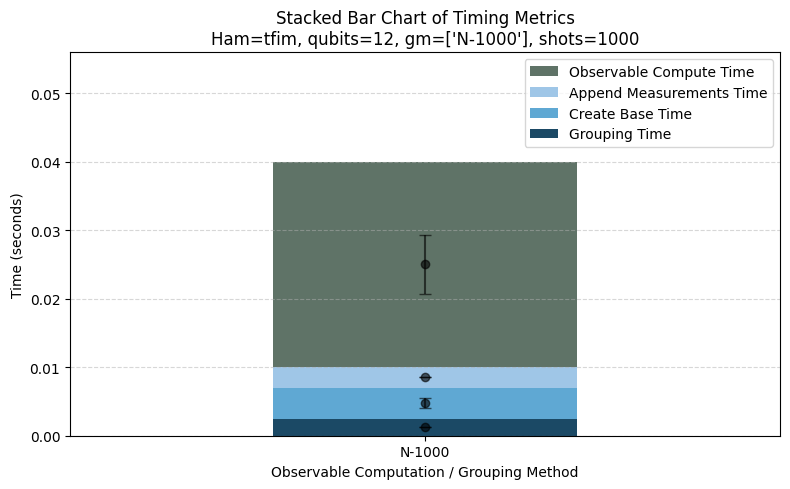

----final errors----
N-1000: 0.284
----final means----
N-1000: -0.217


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

done

... Number of terms in Hamiltonian: 24
... Number of groups created: 2

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/tfim/tfim {'1D-grid': 'pbc', 'h': 2}
    grouping method = N, use_diag_method = True, num_k = 12
    number of terms in Hamiltonian = 24, number of groups created = 2
---N:wsd----

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 0.0021295651938333104
mean: 0.20111410942437277


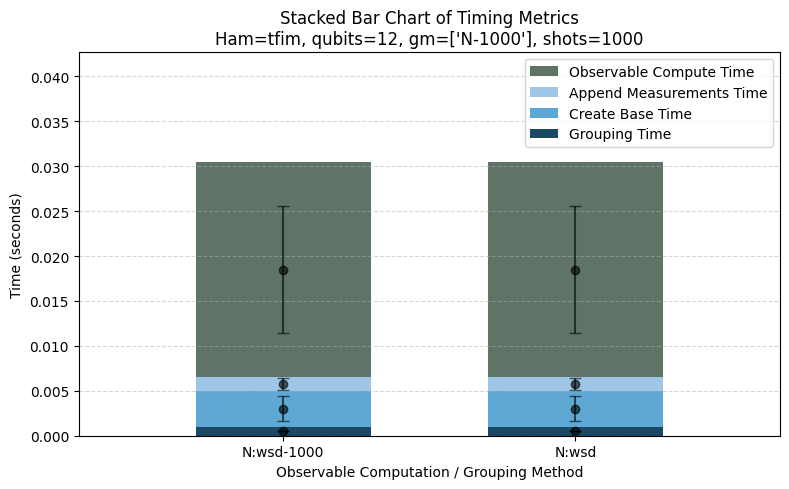

----final errors----
N:wsd-1000: 0.002
----final means----
N:wsd-1000: 0.201


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)
        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

## Heisenburg model

In [11]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[1]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/heisenberg/heis {'1D-grid': 'pbc', 'h': 2}


... dataset_name = graph-1D-grid-pbc-qubitnodes_Lx-12_h-2
... number of terms in Hamiltonian = 48



done

... Number of terms in Hamiltonian: 48
... Number of groups created: 3

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/heisenberg/heis {'1D-grid': 'pbc', 'h': 2}
    grouping method = N, use_diag_method = True, num_k = 12
    number of terms in Hamiltonian = 48, number of groups created = 3
---N----

..
✅ No significant bias detected.
error: 0.39625413939011755
mean: 0.04033053489700622


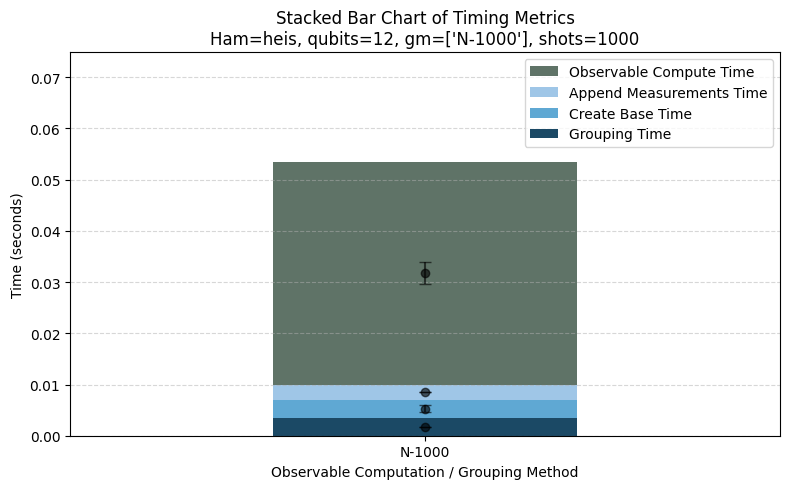

----final errors----
N-1000: 0.396
----final means----
N-1000: 0.040


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

done

... Number of terms in Hamiltonian: 48
... Number of groups created: 3

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/heisenberg/heis {'1D-grid': 'pbc', 'h': 2}
    grouping method = N, use_diag_method = True, num_k = 12
    number of terms in Hamiltonian = 48, number of groups created = 3
---N:wsd----

..
✅ No significant bias detected.
error: 0.3100570584177385
mean: 0.054289585812548224


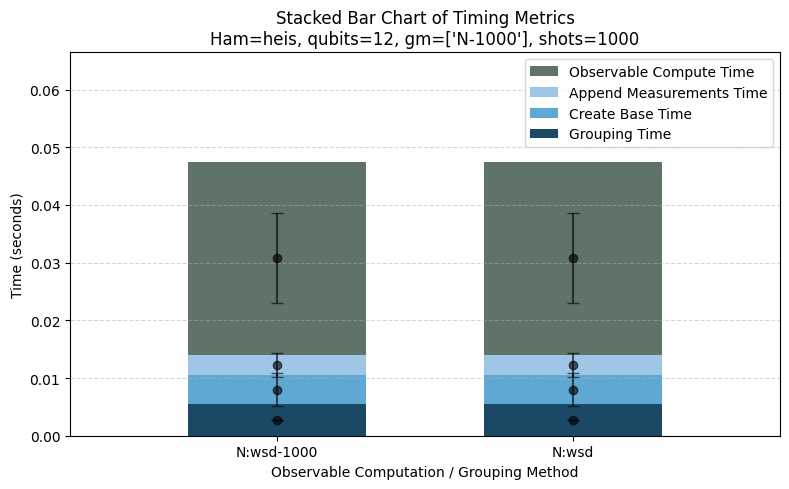

----final errors----
N:wsd-1000: 0.310
----final means----
N:wsd-1000: 0.054


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)
        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [14]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[2]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/fermihubbard/FH_D-1 {'1D-grid': 'pbc', 'enc': 'bk', 'U': 12}


... dataset_name = fh-graph-1D-grid-pbc-qubitnodes_Lx-6_U-12_enc-bk
... number of terms in Hamiltonian = 43



done

... Number of terms in Hamiltonian: 43
... Number of groups created: 4

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/fermihubbard/FH_D-1 {'1D-grid': 'pbc', 'enc': 'bk', 'U': 12}
    grouping method = N, use_diag_method = True, num_k = 12
    number of terms in Hamiltonian = 43, number of groups created = 4
---N----

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.08194018234570244
mean: -0.514435360371456


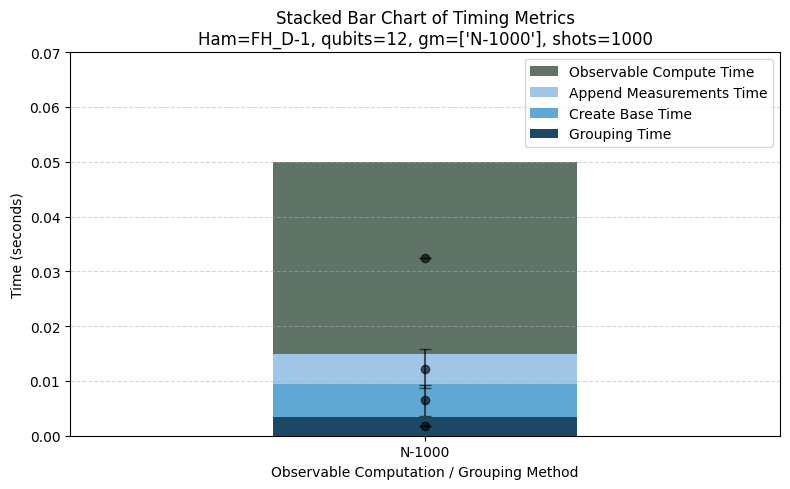

----final errors----
N-1000: 0.082
----final means----
N-1000: -0.514


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

done

... Number of terms in Hamiltonian: 43
... Number of groups created: 4

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/fermihubbard/FH_D-1 {'1D-grid': 'pbc', 'enc': 'bk', 'U': 12}
    grouping method = N, use_diag_method = True, num_k = 12
    number of terms in Hamiltonian = 43, number of groups created = 4
---N:wsd----

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 0.03991327846036263
mean: 0.2625626338339213


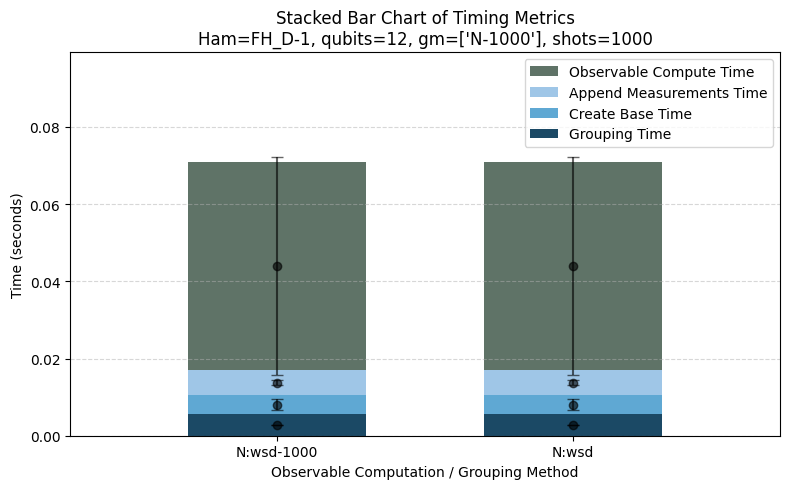

----final errors----
N:wsd-1000: 0.040
----final means----
N:wsd-1000: 0.263


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)
        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [17]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[3]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/bosehubbard/BH_D-1_d-4 {'1D-grid': 'nonpbc', 'enc': 'gray', 'U': 10}


... dataset_name = bh_graph-1D-grid-nonpbc-qubitnodes_Lx-6_U-10_enc-gray_d-4
... number of terms in Hamiltonian = 179



done

... Number of terms in Hamiltonian: 179
... Number of groups created: 11

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/bosehubbard/BH_D-1_d-4 {'1D-grid': 'nonpbc', 'enc': 'gray', 'U': 10}
    grouping method = N, use_diag_method = True, num_k = 12
    number of terms in Hamiltonian = 179, number of groups created = 11
---N----

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 2.9417847045155696
mean: 4.2708463770158005


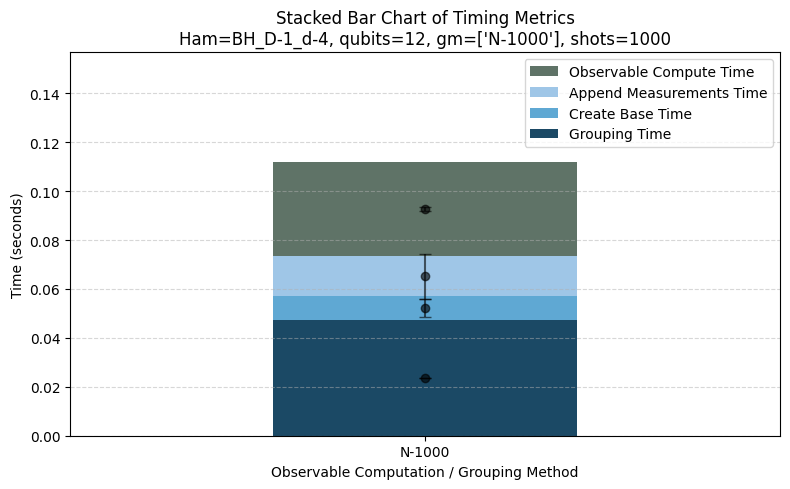

----final errors----
N-1000: 2.942
----final means----
N-1000: 4.271


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

done

... Number of terms in Hamiltonian: 179
... Number of groups created: 11

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/bosehubbard/BH_D-1_d-4 {'1D-grid': 'nonpbc', 'enc': 'gray', 'U': 10}
    grouping method = N, use_diag_method = True, num_k = 12
    number of terms in Hamiltonian = 179, number of groups created = 11
---N:wsd----

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 1.3328529033029284
mean: 1.4390559271230998


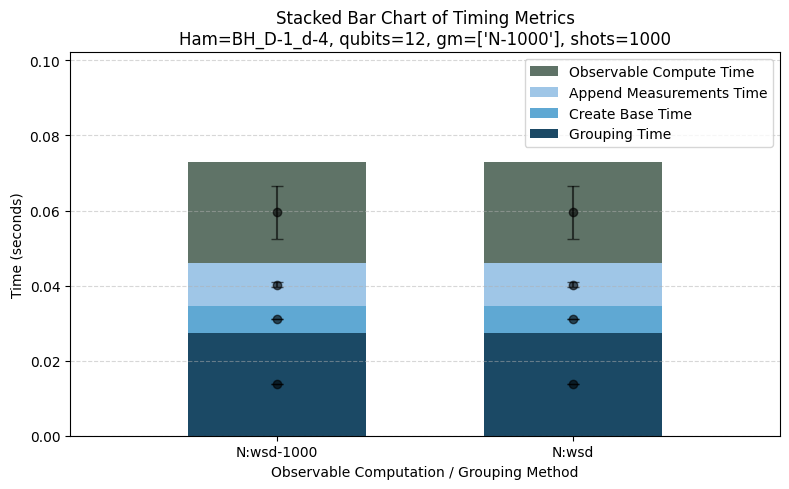

----final errors----
N:wsd-1000: 1.333
----final means----
N:wsd-1000: 1.439


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)
        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [20]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[4]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for chemistry/electronic/standard/H2 {'ham_BK': ''}


... dataset_name = ham_BK-12
... number of terms in Hamiltonian = 327



In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

done

... Number of terms in Hamiltonian: 327
... Number of groups created: 15

... Pauli Term Groups:

Perform Observable Computation for: chemistry/electronic/standard/H2 {'ham_BK': ''}
    grouping method = N, use_diag_method = True, num_k = 12
    number of terms in Hamiltonian = 327, number of groups created = 15
---N----



In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)
        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [ ]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[5]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)
        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [ ]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[6]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)
        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [ ]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[7]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

# group_method_list = [ "N", "N:wsd"]
group_method_list = ["N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    
    for num_shots in num_shots_list:
    
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)
        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
    
    
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{num_shots}" })
        final_errors[f"{group_method_label}-{num_shots}"] = std_error
        final_means[f"{group_method_label}-{num_shots}"] = mean
   
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = []
for num_shots in num_shots_list:
    group_method_labels.append(f'N-{num_shots}')
    
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Organize the data
shot_numbers = [1000, 2500, 4000, 5500, 7000, 8500]
models_data = {
    "TFIM": {
        "N": [0.351, 0.247, 0.196, 0.148, 0.148, 0.132],
        "N:wsd": [0.313, 0.215, 0.185, 0.144, 0.141, 0.106]
    },
    "Heisenburg": {
        "N": [0.438, 0.306, 0.281, 0.217, 0.204, 0.179],
        "N:wsd": [0.489, 0.324, 0.235, 0.198, 0.160, 0.179]
    },
    "Fermi-Hubbard": {
        "N": [0.859, 0.691, 0.521, 0.459, 0.444, 0.436],
        "N:wsd": [0.634, 0.470, 0.450, 0.424, 0.403, 0.387]
    },
    "Bose Hubbard": {
        "N": [3.090, 2.150, 1.600, 1.588, 1.318, 1.285],
        "N:wsd": [1.490, 1.179, 0.819, 0.863, 0.833, 0.758]
    },
    "H2": {
        "N": [0.494, 0.305, 0.292, 0.173, 0.190, 0.172],
        "N:wsd": [0.193, 0.111, 0.097, 0.094, 0.070, 0.077]
    },
    "B2": {
        "N": [0.100, 0.089, 0.059, 0.045, 0.042, 0.039],
        "N:wsd": [0.053, 0.039, 0.034, 0.024, 0.026, 0.021]
    },
    "NH": {
        "N": [0.309, 0.205, 0.156, 0.131, 0.111, 0.109],
        "N:wsd": [0.121, 0.084, 0.071, 0.061, 0.053, 0.056]
    },
    "CH": {
        "N": [0.221, 0.125, 0.092, 0.092, 0.076, 0.064],
        "N:wsd": [0.076, 0.055, 0.038, 0.034, 0.033, 0.031]
    }
}

# Step 2: Plot one grouped bar chart per model
bar_width = 0.35
x = range(len(shot_numbers))

fig, axes = plt.subplots(4, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (model, values) in enumerate(models_data.items()):
    ax = axes[idx]
    ax.bar([i - bar_width / 2 for i in x], values["N"], width=bar_width, label="N", color=plt.cm.Set2(0))
    ax.bar([i + bar_width / 2 for i in x], values["N:wsd"], width=bar_width, label="N:wsd", color=plt.cm.Set2(1))

    ax.set_title(model)
    ax.set_xticks(x)
    ax.set_xticklabels(shot_numbers, rotation=45)
    ax.set_ylabel("Error")
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    if idx == 0:
        ax.legend()

fig.suptitle("Comparison of N vs N:wsd Across Models and Shot Numbers", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Redefine data after kernel reset
models_data = {
    "Bose Hubbard": {
        "N": [3.090, 2.150, 1.600, 1.588, 1.318, 1.285],
        "N:wsd": [1.490, 1.179, 0.819, 0.863, 0.833, 0.758]
    },
    "CH": {
        "N": [0.221, 0.125, 0.092, 0.092, 0.076, 0.064],
        "N:wsd": [0.076, 0.055, 0.038, 0.034, 0.033, 0.031]
    }
}

shot_numbers = [1000, 2500, 4000, 5500, 7000, 8500]
bar_width = 0.35
x = range(len(shot_numbers))

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes = axes.flatten()

for idx, model in enumerate(models_data.keys()):
    values = models_data[model]
    ax = axes[idx]
    ax.bar([i - bar_width / 2 for i in x], values["N"], width=bar_width, label="N", color=plt.cm.Set2(0))
    ax.bar([i + bar_width / 2 for i in x], values["N:wsd"], width=bar_width, label="N:wsd", color=plt.cm.Set2(1))

    ax.set_title(model, fontsize=26)
    ax.set_xticks(x)
    ax.set_xticklabels(shot_numbers, size=26)
    ax.set_ylabel("Error",size=26)
    ax.tick_params(axis='y', labelsize=24)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    if idx == 0:
        ax.legend(fontsize=26)

# fig.suptitle("Error Comparison for Bose Hubbard and CH", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('exp2-b.pdf')
plt.show()


In [ ]:
shot_numbers = [1000, 2500, 4000, 5500, 7000, 8500]
models_data = {
    "TFIM": {
        "N": [0.351, 0.247, 0.196, 0.148, 0.148, 0.132],
        "N:wsd": [0.313, 0.215, 0.185, 0.144, 0.141, 0.106]
    },
    "Heis": {
        "N": [0.438, 0.306, 0.281, 0.217, 0.204, 0.179],
        "N:wsd": [0.489, 0.324, 0.235, 0.198, 0.160, 0.179]
    },
    "FH": {
        "N": [0.859, 0.691, 0.521, 0.459, 0.444, 0.436],
        "N:wsd": [0.634, 0.470, 0.450, 0.424, 0.403, 0.387]
    },
    "BH": {
        "N": [3.090, 2.150, 1.600, 1.588, 1.318, 1.285],
        "N:wsd": [1.490, 1.179, 0.819, 0.863, 0.833, 0.758]
    },
    "H2": {
        "N": [0.494, 0.305, 0.292, 0.173, 0.190, 0.172],
        "N:wsd": [0.193, 0.111, 0.097, 0.094, 0.070, 0.077]
    },
    "B2": {
        "N": [0.100, 0.089, 0.059, 0.045, 0.042, 0.039],
        "N:wsd": [0.053, 0.039, 0.034, 0.024, 0.026, 0.021]
    },
    "NH": {
        "N": [0.309, 0.205, 0.156, 0.131, 0.111, 0.109],
        "N:wsd": [0.121, 0.084, 0.071, 0.061, 0.053, 0.056]
    },
    "CH": {
        "N": [0.221, 0.125, 0.092, 0.092, 0.076, 0.064],
        "N:wsd": [0.076, 0.055, 0.038, 0.034, 0.033, 0.031]
    }
}

condensed_matter_models = ["TFIM", "Heis", "FH", "BH"]
chemistry_models = ["H2", "B2", "NH", "CH"]

In [ ]:
# Updated function with corrected dashed line placement between models
def plot_combined_figure_with_centered_dashes():
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))

    def plot_on_axis(ax, models, title):
        bar_width = 0.35
        group_spacing = 1.0
        model_gap = 2.0
        model_spacing = len(shot_numbers) * group_spacing + model_gap
        selected_shots = {0: "1k", 2: "4k", 4: "7k"}

        xtick_positions = []
        xtick_labels = []

        for m_idx, model in enumerate(models):
            base_x = m_idx * model_spacing

            for i, sn in enumerate(shot_numbers):
                pos = base_x + i * group_spacing
                bar_N_pos = pos - bar_width / 2
                bar_Nwsd_pos = pos + bar_width / 2

                ax.bar(bar_N_pos, models_data[model]["N"][i], width=bar_width,
                       label="N" if m_idx == 0 and i == 0 else "", alpha=0.8, color=plt.cm.Set2(0))
                ax.bar(bar_Nwsd_pos, models_data[model]["N:wsd"][i], width=bar_width,
                       label="N:wsd" if m_idx == 0 and i == 0 else "", alpha=0.8, color=plt.cm.Set2(1))

                if i in selected_shots:
                    ax.text(pos, -0.03, selected_shots[i], ha='center', va='top',
                            fontsize=24, transform=ax.get_xaxis_transform())

            # Model labels
            mid_pos = base_x + (len(shot_numbers) - 1) * group_spacing / 2
            xtick_positions.append(mid_pos)
            xtick_labels.append(model)

            if m_idx < len(models) - 1:
                next_base_x = (m_idx + 1) * model_spacing
                current_end = base_x + (len(shot_numbers) - 1) * group_spacing
                next_start = next_base_x
                separator_pos = (current_end + next_start) / 2
                ax.axvline(x=separator_pos, color='black', linestyle='--', linewidth=1.5)

        for pos, label in zip(xtick_positions, xtick_labels):
            ax.text(pos, -0.12, label, ha='center', va='top',
                    fontsize=30, fontweight='bold', transform=ax.get_xaxis_transform())

        ax.set_xticks([])
        ax.tick_params(axis='y', labelsize=26)
        ax.set_ylabel("Error", fontsize=30)
        ax.set_title(title, fontsize=30)
        ax.legend(fontsize=30)

    plot_on_axis(axes[0], condensed_matter_models, "Condensed Matter Models")
    plot_on_axis(axes[1], chemistry_models, "Chemistry Molecules")

    plt.tight_layout()
    plt.savefig("fig5.pdf")
    plt.show()

# Generate and display the updated figure
plot_combined_figure_with_centered_dashes()
